In [19]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import ast
import numpy as np
plt.style.use('tableau-colorblind10')
from matplotlib.lines import Line2D 

colors = ['#F0E442', '#D55E00', '#009E73', '#4D4D4D', '#56B4E9']  # Blue, Orange, Green, Yellow, Light Blue
colors_blind=[ '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1',  '#FFBC79',  '#C85200','#898989', '#A2C8EC','#006BA4','#CFCFCF',]
from CODES import base_other_codes as bc
from scipy import stats


In [14]:
class plotting_base:
    def __init__(self):
        self.x_fontsize_label=25
        self.y_fontsize_label=25
        self.x_fontsize=20
        self.y_fontsize=20
        self.t_fontsize=20
        self.size_prop=18

        self.row=5
        self.col=3


        self.figure_size=(18,25)
        # figure_size=(10,12)
        self.rotation=30
        self.w_space=0.00001
        self.h_space=None
        self.markersize=5
        self.title_font=18
        self.label_text='% corruption degree'
        self.x_label='Network layers'
        self.pad_value=10
        self.corruptions=[0.0,0.2,0.4,0.6,0.8]
        self.exp1='cor_label'
        self.mapping = {0.0:0,0.2:20, 0.4:40,0.6:60,0.8:80,1.0:100}
        self.mapping2 = {'MNIST':'MNIST','FashionMNIST':'Fashion-MNIST','CIFAR10':'CIFAR-10',
                'CIFAR100':'CIFAR-100','TinyImageNet':'Tiny ImageNet'}
        self.folders = {99:0.99,75:0.75,50:0.50,25:0.25,1:1 }
    def get_corrupt(self,val):
        return self.mapping.get(val, val)

    def get_dataname(self,val):
        return self.mapping2.get(val, val)
    def get_folder_name(self,val):
        return self.folders.get(val, val)
    
    def path_results(self,dataset,type_network,corrupt,seed_value,variance):
        basefolder=f'../sensitivity_ablation_studies/results/{seed_value}/angle_results_{variance}/{dataset}_{type_network}/results_{corrupt}'            
        file_path=f'{basefolder}/angle_results'
        return file_path
    def path_acc(self,dataset,type_network,corrupt):
        accu_path=f'../model_accuracy/{dataset}_{type_network}/{corrupt}'
        return accu_path
    def fun_1(self,train_overall,classnumber=99):
        if classnumber==99:
            max_value = list(map(max, zip(train_overall[0], train_overall[1],train_overall[2])))
            min_value = list(map(min, zip(train_overall[0], train_overall[1],train_overall[2])))
            avg_value = list(map(sum, zip(train_overall[0], train_overall[1],train_overall[2])))
            avg_value = [x/3 for x in avg_value]
        else:
            max_value = list(map(max, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            min_value = list(map(min, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            avg_value = list(map(sum, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            avg_value = [x/3 for x in avg_value]
        return max_value,min_value,avg_value
    def layernames(self,network_type,ds):

        if network_type=='MLP':
            x=[0,1,2,3]
            layers=['FC (128)','FC (512)','FC (2048)','FC (2048)']#'Input',
        if network_type=='CNN':
            if  ds == 'CIFAR10':
                layers=['Flat (1024)','FC (250)','FC (250)','FC (250)']#'Input',
            if  ds != 'CIFAR10':
                layers=['Flat (576)','FC (250)','FC (250)','FC (250)']#'Input',
            x=[0,1,2,3]
        if network_type=='AlexNet':
            x=[0,1,2]
            layers=['Flat (256)','FC (4096)','FC (4096)']
        return x,layers
    
    def epoch_number(self,network_path,corrupt,run):
        models=sorted(os.listdir(f'{network_path}/{corrupt}/Run_{run}'))
        model_numbers = [
            (m, int(m.split("_")[1].split(".")[0]))  
            for m in models if m.startswith("model_") and m.split("_")[1].split(".")[0].isdigit()
        ]
        model_highest = max(model_numbers, key=lambda x: x[1])
        return model_highest[1]
    
    def get_path(self,type_network,ds,corrupt,run):
        network_path=bc.path_network_fn(type_network,ds)
        epoch_number_value=self.epoch_number(network_path,corrupt,run)
        return epoch_number_value
    def path_masc(self,dataset,type_network,corrupt,subspace):
        seed_value=10
        basefolder=f'../sensitivity_ablation_studies/results/{seed_value}/angle_results_0.99'
        basefolder=f'{basefolder}/{dataset}_{type_network}/results_{corrupt}'
        if subspace=='corrupt':
            file_path=f'{basefolder}/angle_results'
        if subspace=='original':
            file_path=f'{basefolder}/angle_results_exp3'
            
        return file_path
    
    def path_pca(self,dataset,type_network,corrupt,subspace):
        seed_value=10
        n_value=0.99
        if type_network in ['CIFAR100','Tiny ImageNet']:
            base_path='/mnt/2TB/simran/MASC/pca_saved/TMLR_compare'
        else:
            base_path='/mnt/SSD1TB/simran/MASC/pca_saved/TMLR_compare'
        results_folder=f'{base_path}/{seed_value}/angle_results_{n_value}/{dataset}_{type_network}'
        file_name=f'{results_folder}/results_{corrupt}/pca_corrupted'
        
        return file_name

In [20]:
class plot_total_time_flops(plotting_base):    
    
    def time_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        time_train_run=[]
        time_test_run=[]
        for run in range(1,runs): 
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            time_train_layer=[]
            time_test_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
                total_train_time=pd.read_csv(file_load)['training_probe time'][0]
                total_test_time=pd.read_csv(file_load)['inference time'][0]
                
                time_train_layer.append(total_train_time)
                time_test_layer.append(total_test_time)
            time_train_run.append(time_train_layer)
            time_test_run.append(time_test_layer)
        return time_train_run,time_test_run
    
    def flops_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        flops_train_run=[]
        flops_test_run=[]
        for run in range(1,runs): 
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            
            flops_train_layer=[]
            flops_test_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
                train_flops=pd.read_csv(file_load)['training_probe flops'][0]
                test_flops=pd.read_csv(file_load)['inference flops'][0]
                flops_train_layer.append(train_flops)
                flops_test_layer.append(test_flops)
            flops_train_run.append(flops_train_layer)
            flops_test_run.append(flops_test_layer)

        return flops_train_run,flops_test_run

    
    def plot_time_flops_probe(self,resfoldername,subspace,flops=False,time=False):
        colors_blind=[ '#006BA4','#5F9ED1','#FF800E', '#ABABAB','#595959', '#A2C8EC','#C85200']
        
        if time:
            y_label='Time taken (in seconds)'
            name_file_pre='TIME'

        if flops:
            y_label='Computational cost (GFLOPs)'   
            name_file_pre='FLOPS'
            
        self.col=4
        dataset=['MNIST','CIFAR10','MNIST','CIFAR10','FashionMNIST','CIFAR100','TinyImageNet']
        type_networks=['MLP','MLP','CNN','CNN','CNN','AlexNet','AlexNet']
        file_name=f'{name_file_pre}_{subspace}_all_masc.pdf'
        labels={'label1':'Build subspaces',
               'label2':'Inference'}
            
        num_rows=2
        figure_size=(15,10)
        fig = plt.figure(figsize=figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

#         for number in range(1,4):
        corrupt=0.0
#             for corrupt in self.corruptions:   
        for ds,type_network in zip(dataset,type_networks):
            fig.add_subplot(num_rows, self.col,count)
            x,layers=self.layernames(type_network,ds)

            probe='MASC'
            file_path=self.path_masc(ds,type_network,corrupt,subspace)
            masc=True
            if time:
                train_run,test_run=self.time_probe(type_network,ds,corrupt,file_path,masc)                    
            if flops:
                train_run,test_run=self.flops_probe(type_network,ds,corrupt,file_path,masc)

            

            max_value,min_value,avg_value=self.fun_1(train_run)
            plt.plot(x,avg_value,'o-',markersize=self.markersize,label=labels[f'label1']
                     ,color=colors_blind[1])
            plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_'
                             ,color=colors_blind[1])
        
            max_value,min_value,avg_value=self.fun_1(test_run)
            plt.plot(x,avg_value,'^-',markersize=self.markersize,label=labels[f'label2']
                     ,color=colors_blind[2])
            plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_'
                             ,color=colors_blind[2])

            plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize-4)
            plt.yticks(fontsize=self.y_fontsize)

#                 if (count - 1) % self.col == 0:
#                     plt.ylabel(f'a',fontsize=self.title_font)
#                 else:
#                     plt.tick_params(labelleft=False)
#             if count<= self.col:
            plt.title(f'{type_network}-{self.get_dataname(ds)}',
                      fontsize=self.t_fontsize,pad=self.pad_value)
    #         if count<= (self.col*num_rows)-self.col:
#             plt.tick_params(labelbottom=False)

            count=count+1
        
        
        
        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=3,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.90])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label-2)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label-2)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
        
                                

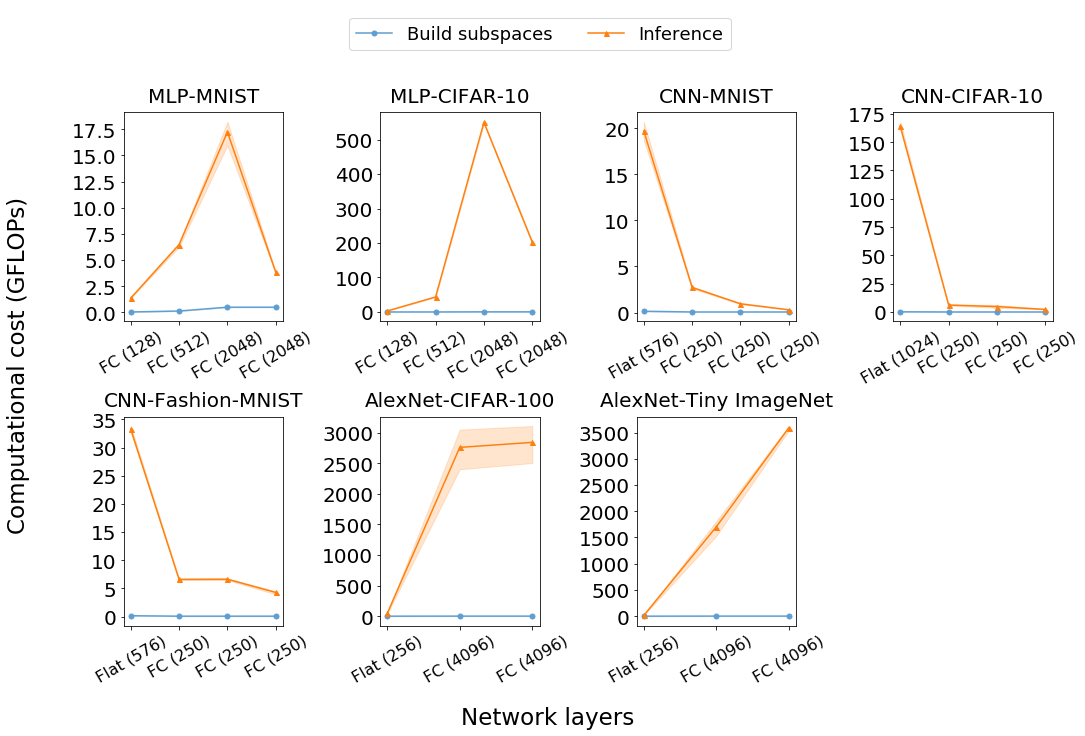

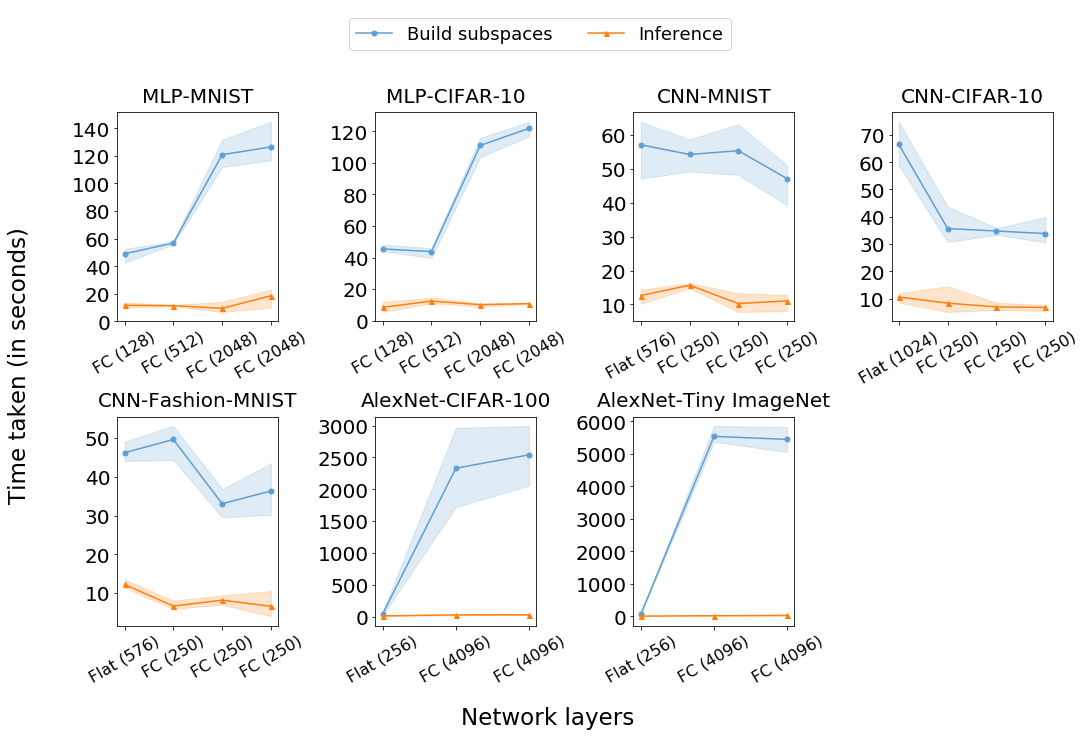

In [21]:
p1=plot_total_time_flops()
subspace='corrupt'
resfoldername='plots/plotting_computational_complexity'
os.makedirs(f'{resfoldername}',exist_ok=True)

p1.plot_time_flops_probe(resfoldername,subspace,flops=True)
p1.plot_time_flops_probe(resfoldername,subspace,time=True)

In [22]:
class plot_total_time_flopsclasswise(plotting_base):    
    
    def time_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        time_train_run=[]
        time_test_run=[]
        for run in range(1,runs): 
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            time_train_layer=[]
            time_test_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_flops.csv'
                total_train_time=pd.read_csv(file_load)['training_probe time'][0]
                total_test_time=pd.read_csv(file_load)['inference time'][0]
                
                time_train_layer.append(total_train_time)
                time_test_layer.append(total_test_time)
            time_train_run.append(time_train_layer)
            time_test_run.append(time_test_layer)
        return time_train_run,time_test_run
    
    def flops_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='flops_estimate'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        flops_train_run=[]
        run=1
#         for run in range(1,runs): 
        epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
        if masc:
            epoch_present=epoch_present-1
        results_path=f'{file_path}/Run_{run}/{epoch_present}'

        flops_train_layer=[]
        for p_layer in pca_layer:
            file_load=f'{results_path}/pca_train_corrupt_{p_layer}_flops.csv'
            train_flops=pd.read_csv(file_load)['flops_estimate'].tolist()
            train_flops = [x / 1e9 for x in train_flops]
#             print(len(train_flops))
            flops_train_layer.append(train_flops)
#         flops_train_run.append(flops_train_layer)

        return flops_train_layer

    
    def plot_time_flops_probe(self,resfoldername,subspace,flops=False,time=False):
        colors_blind=[ '#006BA4','#5F9ED1','#FF800E', '#ABABAB','#595959', '#A2C8EC','#C85200']
        
        if time:
            y_label='Time taken (in sec)'
            name_file_pre='TIME'

        if flops:
            y_label='Computational cost (GFLOPs) for building classwise subspaces'   
            name_file_pre='FLOPS'
            
        self.col=4
        dataset=['MNIST','CIFAR10','MNIST','CIFAR10','FashionMNIST','CIFAR100','TinyImageNet']
        type_networks=['MLP','MLP','CNN','CNN','CNN','AlexNet','AlexNet']
        file_name=f'{name_file_pre}_{subspace}_perclass_masc.pdf'
#         classes=[0,1,2,3,4,5,6,7,8,9]

            
        num_rows=2
        figure_size=(15,10)
        fig = plt.figure(figsize=figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

#         for number in range(1,4):
        corrupt=0.2
#             for corrupt in self.corruptions:   
        for ds,type_network in zip(dataset,type_networks):
            fig.add_subplot(num_rows, self.col,count)
            x,layers=self.layernames(type_network,ds)

            probe='MASC'
            
            masc=True
            if time:
                file_path=self.path_masc(ds,type_network,corrupt,subspace)
                train_run,test_run=self.time_probe(type_network,ds,corrupt,file_path,masc)        
                
            if flops:
                file_path=self.path_pca(ds,type_network,corrupt,subspace)
                train_run=self.flops_probe(type_network,ds,corrupt,file_path,masc)

            plt.plot(x,train_run,'o-',markersize=self.markersize)


            plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize-4)
            plt.yticks(fontsize=self.y_fontsize)

            plt.title(f'{type_network}-{self.get_dataname(ds)}',
                      fontsize=self.t_fontsize,pad=self.pad_value)


            count=count+1
        
        
        
#         fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
#                    ncol=3,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.90])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label-6)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label-2)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
        
                                

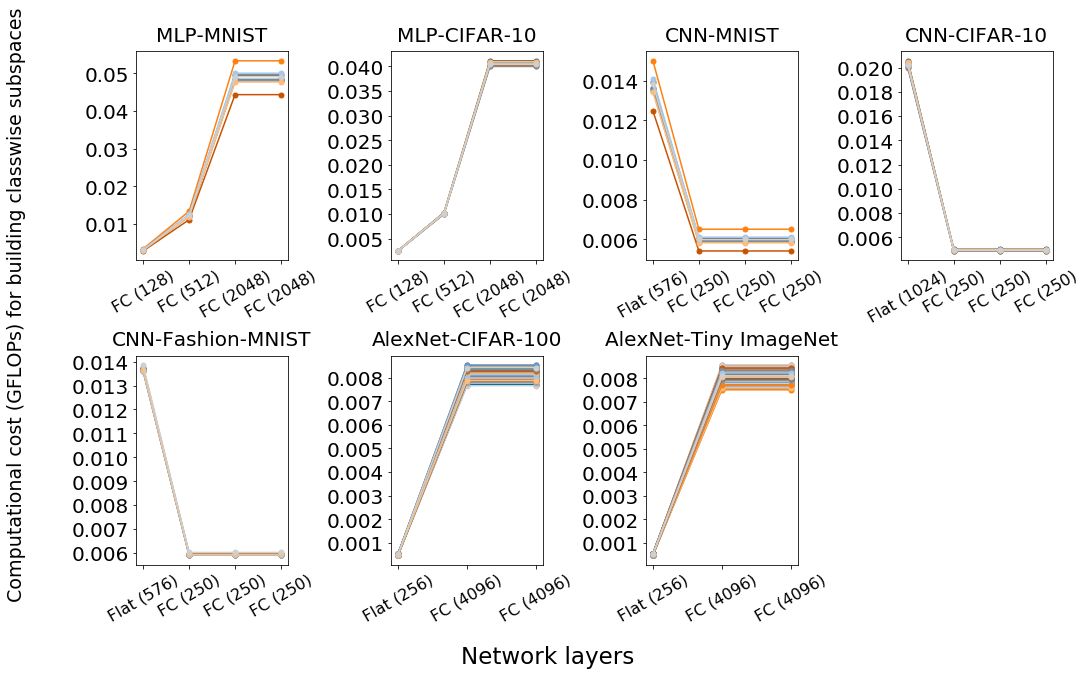

In [23]:
p1=plot_total_time_flopsclasswise()
subspace='corrupt'
resfoldername='plots/plotting_computational_complexity'
os.makedirs(f'{resfoldername}',exist_ok=True)

p1.plot_time_flops_probe(resfoldername,subspace,flops=True)
